In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3
from tqdm import tqdm
#import imageio as im
#from IPython.display import Image
#import cv2
import time
#from multiprocessing import Pool

In [2]:
#Global variables and conversions
global G
G = 6.7e-11 # Newton gravitational constant
m_to_AU = 6.68459e-12 #meter to AU conversion 

In [3]:
#Body object
class body:
    def __init__(self,index,pos=np.array([0.0001,0,0]),radius=0,mass=0,vel=np.array([0,0,0]),
                 momentum=np.array([0,0,0]),get_e=0,center_body=0
                 ,get_inclination=0,get_obliq=0,get_prec=0,s=1,c='k'):
        
        #Metadata
        self.index = index
        self.s = s #point size on graph
        self.c = c #color on graph
        
        #scalar quantities
        self.radius = radius
        self.mass = mass

        #vector quantities
        self.pos = pos
        self.vel = vel
        self.momentum = momentum

        #Body's position vectors
        #These vectors point from this body to all other bodies in the system
        self.r = []
        self.r_hat = []
        self.r_mag = []
        
        #arrays to track vector quantities
        self.posA = []
        self.momentumA = []
        
        #Current force on body:
        self.current_F = np.zeros(3)
        
        #Eccentricity and orbital shape
        self.get_e = get_e #Do I want to track the eccentricity of this body?
        self.e_vec = np.zeros(3) #The eccentricity vector.
        self.center_body = center_body #which other body in the system I want the eccentricity relative to
        self.r_apoapsis = np.zeros(3) #The position vector of the apoapsis
        self.apoapsis_mag = np.linalg.norm(self.r_apoapsis) #mag of apoapsis
        self.r_periapsis = np.array([1e20,1e20,1e20]) #initial periapsis
        self.periapsis_mag = np.linalg.norm(self.r_periapsis) #mag of periapsis
        self.e = (self.apoapsis_mag-self.periapsis_mag)/(self.apoapsis_mag+self.periapsis_mag) #instantaneous eccentricity
        self.eA = [] #array to hold instantaneous eccentricities
        
        self.semimajor = self.apoapsis_mag - self.periapsis_mag #orbital semimajor axis
        
        self.year = 0
        
        #For some bodies that have useful orbital inclinations
        self.get_inclination = get_inclination #Do I want to track this body's inclination?
        self.inclination = 0 #current/initial inclination
        self.inclinationA = [] #array tracking inclination
        
        #obliquity
        self.get_obliq = get_obliq #Do I want to track this body's obliquity?
        self.obliquity = 0 #current/initial obliquity
        self.obliq_A = [] #array to track obliquity
        
        #precession
        self.get_prec = get_prec #Do I want to track this body's precession?
        self.precession = 0 #current precession, in degrees
        self.precessionA = [] #array to track precession
    
    #Initiate Momentum - get the initial momentum array
    def init_momentum(self,verbose=0):
        self.momentum = self.vel*self.mass
        if verbose:
            print("Current momentum: ",self.momentum)
    
    ##################################################################
    #Update functions
    ##################################################################
    def update_momentum(self,dt,verbose=0):
        self.momentum = self.momentum + self.current_F*dt
        if verbose:
            print("Current momentum: ",self.momentum)
    
    def update_pos(self,dt,verbose=0):
        self.pos = self.pos + (self.momentum / self.mass) * dt
        if verbose:
            print("Current position: ",self.pos)
            
    #Updates orbital shape parameters, like eccentricity, apoapsis and periapsis, semimajor axis, and inclination
    def update_orbit_shape(self,c_body):
        if self.get_e:
            #ECCENTRICITY, APOAPSIS, PERIAPSIS, SEMIMAJOR
            #get the periapsis and apoapsis of the planet around its central body
            #If current point is farther than farthest point; new apoapsis
            if self.r_mag[self.center_body] > self.apoapsis_mag:
                self.r_apoapsis = self.pos - c_body.pos
                self.apoapsis_mag = np.linalg.norm(self.r_apoapsis)

            #If current point is closer than closest point; new periapsis
            if self.r_mag[self.center_body] < self.periapsis_mag:
                self.r_periapsis = self.pos - c_body.pos
                self.periapsis_mag = np.linalg.norm(self.r_periapsis)

            #Update the samimajor axis length!
            self.semimajor = (self.apoapsis_mag + self.periapsis_mag)/2 #average of the periapsis and apoapsis distance
            
            self.year = (( (self.periapsis_mag*m_to_AU) + (self.apoapsis_mag*m_to_AU) )/(2))**(3/2) #2*np.pi*np.sqrt(self.semimajor**3 / (G*self.mass))

            self.update_eccentricity(c_body)

        #If this body is tracking inclination, update the inclination!
        if self.get_inclination:
            self.inclination = get_angle_from_flat(self,c_body) #get_angle gives degrees
    
    #Update the tracking arrays
    def update_arrays(self,t):
        self.posA.append(self.pos)
        self.momentumA.append(self.momentum)

        #If this body is tracking inclination:
        if self.get_inclination:
            self.inclinationA.append(self.inclination) #in degrees

        #If this body is tracking obliquity:
        if self.get_obliq:
            self.obliquity = obliquity(t/(np.pi*1e7))
            self.obliq_A.append(self.obliquity)

        #If this body is tracking eccentricity and orbital shape:
        if self.get_e:
            self.eA.append(self.e)

        #If this body is tracking precession
        if self.get_prec:
            self.precessionA.append(self.precession)
    
    #Update the eccentricity
    def update_eccentricity(self,c_body,verbose=0):
        v_rel = -self.vel + c_body.vel
        r_rel = -self.pos + c_body.pos
        mu = G*self.mass
        
        self.e = (self.apoapsis_mag-self.periapsis_mag)/(self.apoapsis_mag+self.periapsis_mag)
        if verbose:
            print("Magnitude: ",self.e)

Plotting graph...


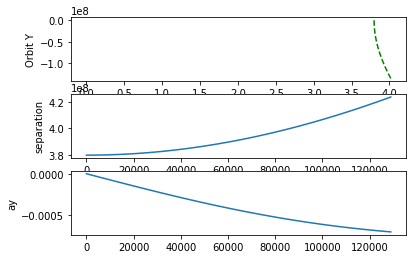

Simulation Complete


In [8]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

mE = 5.9742e24      #earth mass
mM = 7.35e22        #moon mass
dM = 379728240.5    #distance from moon to barycentre
dE = 4671759.5      #distance from earth to barycentre

s = 6.4686973e7     #hypothesised distance from moon to Lagrange-2 point
sr = 6.5420e7       #alternate L2 distance

def Simulate(iterations):

    x = dM                                                  #initialise     rocket positions
    y = 0
    a = 1                                                  #set the time step
    xdot = 0.                                                #initialise rocket velocity
    ydot = -((6.6726e-11)*mE/x)**0.5
    rocket_history_x, rocket_history_y = [[] for _ in range(2)] 
    history_mx, history_my = [[] for _ in range(2)]
    history_ex, history_ey = [[] for _ in range(2)]
    sep_history, step_history = [[] for _ in range(2)]      #create lists to store data in
    history_vx, history_vy = [[] for _ in range(2)]
    history_ax, history_ay = [[] for _ in range(2)]
    n = 1500
    m = 10000                                               #n,m,p are for storing every nth, mth and pth value to the lists
    p = 60000
    r = np.array((x,y))                                        #create rocket position vector
    v = np.array((xdot, ydot))                                 #create rocket velocity vector

    for i in range(iterations):

        xe, ye = 0, 0                                            #position of earth
        re = np.array((xe,ye))                                     #create earth position vector

        phi = np.arctan2((r[1]-ye),(r[0]-xe))                       #calculate phi, the angle between the rocket and the earth, as measured from the earth
        r_hat_e = np.array((np.cos(phi), np.sin(phi)))             #create vector along which earth's acceleration acts

        def acc(r):                                                             #define the acceleration vector function                                                
            return ((-G)*(mE)/abs(np.dot((r-re),(r-re)))**1.5)*(r-re)

        k1v = acc(r)                         #use RK4 method
        k1r =     v
        k2v = acc(r + (a/2) * k1r)            
        k2r =     v + (a/2) * k1v            
        k3v = acc(r + (a/2) * k2r)            
        k3r =     v + (a/2) * k2v          
        k4v = acc(r +  a    * k3r)                
        k4r =     v +  a    * k3v

        v = v + (a/6) * (k1v + 2*k2v + 2*k3v + k4v)              #update v
        r = r + (a/6) * (k1r + 2*k2r + 2*k3r + k4r)              #update r

        sep = np.sqrt(np.dot((r-re),(r-re)))                    #separation of rocket and earth, useful for visualisation/trouble-shooting


        if i% n == 0: # Check for the step
            rocket_history_x.append(r[0])
            rocket_history_y.append(r[1])
            history_ex.append(xe)
            history_ey.append(ye)
            sep_history.append(sep)                             #putting data into lists for plotting and troubleshooting
            step_history.append(i)
            history_ax.append(acc(r)[0])
            history_ay.append(acc(r)[1])
            history_vx.append(v[0])
            history_vy.append(v[1])

        #if i% m == 0: # Check for the step
            #print r
            #print acc(r)
        #if i% p == 0: # Check for the step
            #print ((a/6)*(k1v + 2*k2v + 2*k3v + k4v))
            #print ((a/6)*(k1r + 2*k2r + 2*k3r + k4r))
            #print k1v, k2v, k3v, k4v
            #print k1r, k2r, k3r, k4r


    return rocket_history_x, rocket_history_y, history_ex, history_ey, history_mx, history_my, sep_history, step_history, history_ax, history_ay, history_vx, history_vy



x , y, xe, ye, mx, my, sep, step, ax, ay, vx, vy = Simulate(130000)


#print x,y,vx,vy,ax,ay,step

print ("Plotting graph...")



plt.figure()
plt.subplot(311)

plt.plot(x, y, linestyle='--', color = 'green')
#plt.plot(mx, my, linestyle='-', color = 'blue')
plt.plot(xe, ye, linestyle='-', color = 'red')
#plt.plot(xm, ym)
plt.xlabel("Orbit X")
plt.ylabel("Orbit Y")
'''
plt.plot(step, vy)
plt.ylabel("vy")
'''
plt.subplot(312)
plt.plot(step, sep)
plt.xlabel("steps")
plt.ylabel("separation")

plt.subplot(313)
plt.plot(step, ay)
plt.ylabel("ay")



plt.show()



print("Simulation Complete")